### Steane [[7, 1, 3]], phenomenological model

Depolarization channel: 
$$\rho\rightarrow (1-p)\rho + \frac{p}{3}X\rho X + \frac{p}{3}Y\rho Y + \frac{p}{3}Z\rho Z$$

Each syndrome measurement has probability $p$ to go wrong. Therefore we need to do $d$ rounds of measurement then apply error correction based on the majority vote result:
- $>d/2$ rounds of syndrome: qubit error -> correct 
- $<d/2$ rounds of syndrome: measurement error -> ignore 

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rand
from tqdm import tqdm

In [2]:
def steane_Err():
    # col 1: X error
    # col 2: Z error
    return np.zeros((7, 2))

In [3]:
# Apply depolarization channel
def AddError(p, P_matrix):
    for i in range(7):
        r1 = rand.random()
        if r1 < p:
            r2 = rand.random()
            if r2 < 1/3:
                P_matrix[i][0] = 1        # p/3 X
            elif r2 > 2/3:
                P_matrix[i][1] = 1        # p/3 Z
            else:
                P_matrix[i][0] = 1
                P_matrix[i][1] = 1        # p/3 Y
    return P_matrix

In [4]:
# Error occurred during measurement, add to check matrix in each round
def meas_err(p):
    meas_err = np.zeros((2, 3))
    for i in range(2):
        for j in range(3):
            r = np.random.random()
            if r < p:
                meas_err[i][j] = 1
    return meas_err

In [31]:
def Decoder(P_matrix, p=0, d: int=3):
    
    # Detect
    H = np.array([[1, 1, 1, 1, 0, 0, 0],
                  [0, 1, 1, 0, 1, 1, 0],
                  [0, 0, 1, 1, 0, 1, 1]]).transpose()
    check = np.mod(np.dot(P_matrix.transpose(), H), 2)
    
    # Decode
    syndrome_list = np.array([[1, 0, 0],
                              [1, 1, 0],
                              [1, 1, 1],
                              [1, 0, 1],
                              [0, 1, 0],
                              [0, 1, 1],
                              [0, 0, 1]])
    correct = np.zeros((7, 2))
    
    # d rounds of measurement, each with measurement error of probability p
    for rnd in range(d):
        _check = check + meas_err(p)
        for i in range(7):
            for j in range(2):
                if (syndrome_list[i] == _check[j]).all():
                    correct[i][j] += 1
                    
    # # Majority vote
    for i in range(7):
        for j in range(2):
            correct[i][j] = (correct[i][j] > float(d)/2)

    return (np.sum((correct+P_matrix)[4:], axis=0)%2)

In [32]:
# Example, adding random error, syndrome
P = steane_Err()
p = 0.001
P_ = AddError(p, P)
Decoder(P_, p)

array([0., 0.])

In [33]:
num_exp = 10000
len_list = 11
# p_list = np.linspace(0, 0.2, len_list)
p_list = np.logspace(-2, -0.7, len_list)

In [37]:
result_list = np.ones(len_list)*num_exp
result_list_cc = np.ones(len_list)*num_exp

for j in range(len_list):
    for i in tqdm(range(num_exp)):
        P_ = AddError(p_list[j], steane_Err())
        if np.sum(Decoder(P_, p_list[j])) == 0:
            result_list[j] -= 1
        if np.sum(Decoder(P_, 0)) == 0:
            result_list_cc[j] -= 1

result_list /= num_exp
result_list_cc /= num_exp

100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 3345.45it/s]


Text(0, 0.5, 'Logical error rate')

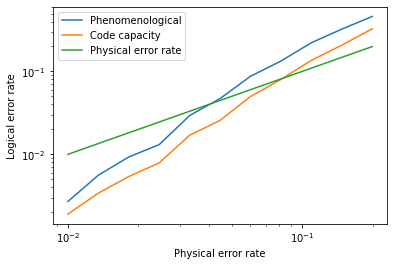

In [38]:
plt.loglog(p_list, result_list, label='Phenomenological')
plt.loglog(p_list, result_list_cc, label='Code capacity')
plt.loglog(p_list, p_list, label='Physical error rate')
plt.legend()
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
# plt.title('Phenomenological model')